In [1]:
%load_ext autoreload
%autoreload 2

import os  
import sys 
from PIL import Image 
sys.path.append("..")
os.environ['JAX_PLATFORMS'] = 'cpu'

from typing import Callable 

import jax
import jax.numpy as jnp
import jax.random

from kinetix.environment.env import make_kinetix_env_from_args
from kinetix.environment.env_state import StaticEnvParams, EnvParams, EnvState
from kinetix.environment.wrappers import LogEnvState
from kinetix.environment.ued.ued_state import UEDParams
from kinetix.environment.ued.distributions import sample_kinetix_level
from kinetix.render.renderer_pixels import make_render_pixels

from transformers import AutoProcessor, FlaxCLIPModel
import matplotlib.pyplot as plt 

/Users/ericliu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step calculations 
*** 

In [106]:
num_steps = 512
num_train_envs = 2048 

total_time_steps = 1073741824

num_updates = total_time_steps / (num_steps * num_train_envs)
print(num_updates)



1024.0


In [107]:
eval_freq = 128 

num_evals = num_updates / eval_freq
num_evals 

8.0

# Experiment
*** 

In [2]:
# Use default parameters
env_params = EnvParams()
static_env_params = StaticEnvParams()
ued_params = UEDParams()
renderer = make_render_pixels(env_params, static_env_params) 

In [33]:
type(renderer)

jaxlib.xla_extension.PjitFunction

In [98]:
# Create the environment
env = make_kinetix_env_from_args(
    obs_type="symbolic", 
    action_type="continuous", 
    reset_type="replay", 
    static_env_params=static_env_params,
)

In [99]:
# Sample a random level
rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)

In [100]:
level:EnvState = sample_kinetix_level(_rng, env.physics_engine, env_params, static_env_params, ued_params)

rng, _rng = jax.random.split(rng)
obs, env_state = env.reset_to_level(_rng, level, env_params)

In [117]:
env_state.env_state.env_state.env_state.polygon.radius.shape

(12,)

In [118]:
def _get_pixels(renderer:Callable, state:LogEnvState) -> jnp.ndarray: 
    return renderer(env_state.env_state.env_state.env_state)

pixels = _get_pixels(renderer, env_state)

In [119]:
obs.shape 

(1675,)

In [95]:
pixels = pixels.astype(jnp.float64)

/Users/ericliu/miniconda3/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [96]:
@jax.jit 
def upsample_image(image):
    """Upsamples image from (125,125,3) to (224,224,3) using bilinear interpolation"""
    return jax.image.resize(
        image,
        shape=(224, 224, 3),
        #method= "lanczos3"
        #method="bilinear"  # or "nearest", "bicubic", "lanczos3"
    )


@jax.jit
def pad_image(image):
    """Pads image from (125,125,3) to (224,224,3) by adding zeros around it"""
    # Calculate padding needed on each side
    pad_size = (224 - 125) // 2  # = 49 pixels on each side
    extra = (224 - 125) % 2  # Handle odd difference if any
    
    # Pad with zeros - format is ((before_dim1, after_dim1), (before_dim2, after_dim2), (before_dim3, after_dim3))
    return jnp.pad(
        image,
        pad_width=(
            (pad_size, pad_size+extra),  # Height padding
            (pad_size, pad_size+extra),  # Width padding
            (0, 0)  # No padding for channels
        ),
        mode='constant',
        constant_values=0
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36516294..1.2949235].


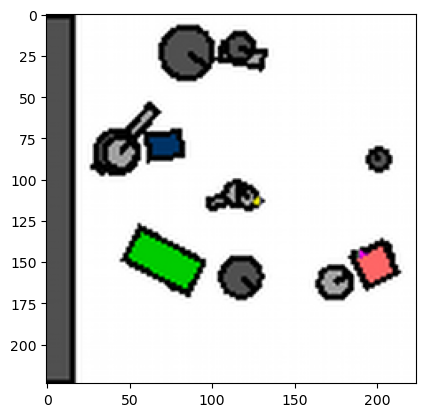

In [97]:
plt.imshow(pixels);

In [69]:
pixels = upsample_image(pixels)
#pad_image(pixels)

#upsample_image(pixels)

pixels.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36516294..1.2949235].


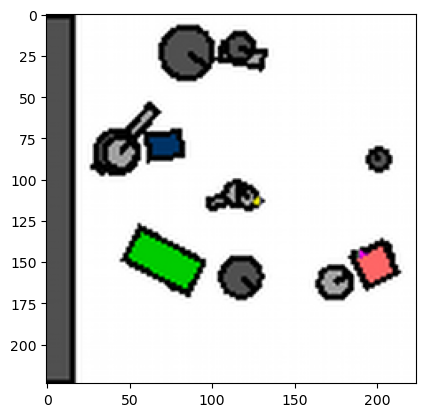

In [70]:
plt.imshow(pixels);
#plt.imsave("random.png", pixels)

In [84]:
model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.get_image_features = jax.jit(model.get_image_features)
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [85]:
#inputs = processor(images=Image.open("random.png"), return_tensors="np")

In [86]:
#inputs["pixel_values"].shape, type(inputs["pixel_values"])

In [91]:
embeds = jax.lax.stop_gradient(
    model.get_image_features(
        pixel_values= 
            jnp.transpose(
                jnp.expand_dims(pixels, 0),
                (0, 3, 1, 2),
            )
    )
)
embeds.shape 

(1, 512)